# Notebook for implementing modifications to covariance matrix code make_Cmatrix.py
 Instructions: “We would like for him to take his existing code sample, encapsulate it (put it into an object oriented format) and be able to speak to how he went about that in his second interview round.”


In [42]:
# check some masks
from astropy.io import fits

maskFile0 = '/Data/PSG/small_masks/ISWmap_din1_R060_trunc1.fits' # not a mask; it won't behave as one
maskFile1 = '/Data/sparsemask_1.fits'
maskFile2 = '/Data/sparsemask_2.fits'
maskFile3 = '/Data/sparsemask_3.fits'

maskFile = maskFile2
hdu1 = fits.open(maskFile)
hdu1.info()
#print hdu1[1].header
print hdu1[1].header['ORDERING']
print hdu1[1].header['NSIDE']

hdu1.close()

Filename: /Data/sparsemask_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       7   ()      
  1                1 BinTableHDU     24   48R x 1C   [1024E]   
NESTED
64


NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
(49152,)
100.0


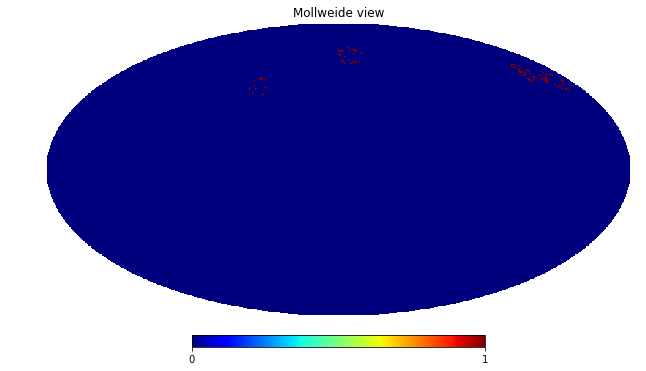

In [51]:
nested = True
mask = hp.read_map(maskFile,nest=nested)
print mask.shape
print np.sum(mask)

hp.mollview(mask, nest=True)
plt.show()

In [48]:
# Copy the old code here and verify that it still runs.
# Modified /shared/Data to /Data; ZK, 2019.01.28

#! /usr/bin/env python
"""
  NAME:
    make_Cmatrix.py
  PURPOSE:
    Program to create a covariance matrix for a given set of HEALpix pixels.
  USES:
    fits file containing mask indicating the set of pixels to use
    fits file containing ISWout power spectrum
      where ISWout indicates no ISW for 0.4 < z < 0.75
  MODIFICATION HISTORY:
    Written by Z Knight, 2015.09.14
    Added subMatrix; ZK, 2015.09.21
    Added symSave, symLoad; ZK, 2015.09.29
    Added RDInvert; ZK, 2015.10.29
    Switched pyfits to astropy.io.fits; ZK, 2015.11.09
    Switched showCl scaling to l(l+1) from l(l-1); ZK, 2015.11.13
    Added beamSmooth, pixWin parameters to makeCmatrix;
      changed highpass parameter default to 0; ZK, 2015.12.04
    Added cMatCorrect function; ZK, 2015.12.08
    Added choInvert function; ZK, 2015.12.09
    Added lmax and useMicro parameters to makeCmatrix;
      Fixed indexing problem where makeCmatrix was missing
        diagonal below main; ZK, 2015.12.11
    Added nested parameter; ZK, 2016.01.09
    Added error checking for subMatrix; ZK, 2016.01.14
    Removed forSMICA functionality from makeCmatrix, as it belongs
      in filter_map and was erroneously copied here; ZK, 2016.01.18
    Split subMatrix into subMatrix and subMatrix2. The second version
      can take data arrays wheras the first takes filenames; ZK, 2016.01.20

"""

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
#import pyfits as pf
import astropy.io.fits as pf
from numpy.polynomial.legendre import legval
from scipy.special import legendre
import time # for measuring duration

def symSave(saveMe,saveFile='symsave'):
  """
    Turns symmetric matrix into a vector and saves it to disk.
    INPUTS:
      saveMe: the symmetric numpy 2d array to save
      saveFile: the file name to save.  .npy will be appended if not already present
        default: symsave.npy
  """
  indices = np.triu_indices_from(saveMe)
  np.save(saveFile,saveMe[indices])

def symLoad(loadFile='symsave.npy'):
  """
    loads a numpy .npy array from file and transforms it into a symmetric array
    INPUTS:
      loadFile: the name of the file to load
        default: symsave.npy
    Returns a symmetric 2d numpy array
  """
  loaded = np.load(loadFile)
  n = -1/2.+np.sqrt(1/4.+2*loaded.size)
  array = np.zeros([n,n])
  indices = np.triu_indices(n)
  array[indices]=loaded
  return array+np.transpose(array)-np.diag(np.diag(array))


def getCl(filename):
  """
    opens a CAMB FITS file and extracts the Power spectrum
    filename: the name of the FITS file to open
    returns two arrays: one of ell, one of C_l
  """
  powSpec = pf.getdata(filename,1)
  temps = powSpec.field('TEMPERATURE')
  ell = np.arange(temps.size)
  return ell,temps

def showCl(ell,temps,title='CAMB ISWout power spectrum'):
  """
    create a plot of power spectrum
    ell: the multipole number
    temps: the temperature power in Kelvin**2
    title : the title for the plot
    uses ell*(ell+1)/2pi scaling on vertical axis
  """
  plt.plot(ell,temps*ell*(ell+1)/(2*np.pi) *1e12) #1e12 to convert to microK**2
  plt.xlabel('multipole moment l')
  plt.ylabel('l(l+1)C_l/(2pi) [microK**2]')
  plt.title(title)
  plt.show()

def makeLegendreTable(lmax,saveFile='legtab'):
  """
    function to create a table of legendre polynomial coefficients and save it to file
    table will be a square array
    columns correspond to powers of x starting with x^0 in the left most column
    INPUTS:
      lmax: the highest l value to be calculated
      saveFile: the name of the numpy save file.  If not already present, '.npy' will
        be appended.
        Default: legtab.npy

  # this works fine for small lmax values, but ell=86 and higher have problems
  #   possibly due to exceeding the maximum size of a float64 dtype
  """
  coefs = np.zeros((lmax+1,lmax+1))
  for ell in range(lmax+1):
    cs = legendre(ell)
    coefs[ell,:ell+1] = cs.coeffs[::-1]
  symSave(coefs,saveFile)

def powerArray(x,powMax):
  """
    function to create an array of powers of x, starting from x^0
    returns a powMax+1 length numpy array
  """
  pows = np.array([1])
  for power in range(1,powMax):
    pows = np.concatenate((pows,np.array([pows[power-1]*x])))
  return pows


def makeCmatrix(maskFile, powerFile, highpass = 0, beamSmooth = True, pixWin = True,
                lmax=2000, useMicro=False, nested=False):
  """
    function to make the covariance matrix
    maskFile: a healpix fits file name that contains 1 where a pixel is to be included
      in covariance matrix and 0 otherwise
      Must be NSIDE=64
    powerFile: a CAMB CMB power spectrum file with units K**2
    highpass: the lowest multipole l to not be zeroed out.
      Default is 0
    beamSmooth: determines whether to use beamsmoothing on C_l,
      also control lmax
      Default is True, with lmax = 250
    pixWin: determines whether to use the pixel window,
      also controls lmax
      Default is True, with lmax = 250
    lmax: maximum l value in Legendre series.
      Note: this value is overridden by beamSmooth and pixWin lmax settings
      Default is 2000
    useMicro: converts power spectrum units from K**2 to microK**2 before calculating matrix
    returns the covariance matrix, with units K**2 or microK**2, depending on value of useMicro parameter
    nested: NESTED vs RING parameter to be used with healpy functions
      IMPORTANT!!! Note that nested parameter used to create C matrix must match that used
        in every function that uses the C matrix
      Default is False
  """
  # read mask file
  mask = hp.read_map(maskFile,nest=nested)

  # read power spectrum file
  ell,C_l = getCl(powerFile)

  # read coordinates file
  if nested:
    coordsFile64 = '/Data/pixel_coords_map_nested_galactic_res6.fits'
  else:
    coordsFile64 = '/Data/pixel_coords_map_ring_galactic_res6.fits'
  gl,gb = hp.read_map(coordsFile64,(0,1),nest=nested)

  # isolate pixels indicated by mask
  #myGl = np.array([gl[index] for index in range(gl.size) if mask[index] == 1])
  #myGb = np.array([gb[index] for index in range(gb.size) if mask[index] == 1])
  myGl = gl[np.where(mask)]
  myGb = gb[np.where(mask)]
  #print 'mask size: ',myGl.size,' or ',myGb.size

  # convert to unit vectors
  unitVectors = hp.rotator.dir2vec(myGl,myGb,lonlat=True)
  print unitVectors.shape
  
  # create half (symmetric) matrix of cosine of angular separations
  # this takes about 67 seconds for 6110 point mask
  vecSize = myGl.size
  cosThetaArray = np.zeros([vecSize,vecSize])
  for row in range(vecSize): #or should this be called the column?
    cosThetaArray[row,row] = 1.0 # the diagonal
    for column in range(row+1,vecSize):
      cosThetaArray[row,column] = np.dot(unitVectors[:,row],unitVectors[:,column])
      #if cosThetaArray[row,column] != cosThetaArray[row,column]:
      #  print 'NaN at row: ',row,', column: ',column

  print cosThetaArray
  
  # create beam and pixel window expansions and other factor
  if pixWin:
    lmax = 250
    Wpix = hp.pixwin(64)
    W_l = Wpix[:lmax+1]
  else:
    W_l = 1.0
  if beamSmooth:
    lmax = 250
    B_l = hp.gauss_beam(120./60*np.pi/180,lmax=lmax) # 120 arcmin to be below W_l
  else:
    B_l = 1.0
  print "lmax cutoff imposed at l=",lmax

  fac_l = (2*ell[:lmax+1]+1)/(4*np.pi)
  C_l = np.concatenate((np.zeros(highpass),C_l[highpass:]))
  if useMicro: # convert C_l units from K**2 to muK**2:
    C_l = C_l * 1e12
  preFac_l = fac_l *B_l**2 *W_l**2 *C_l[:lmax+1]

  # evaluate legendre series with legval
  covArray = np.zeros([vecSize,vecSize])
  for row in range(vecSize):
    print 'starting row ',row
    for column in range(row,vecSize):
      covArray[row,column] = legval(cosThetaArray[row,column],preFac_l)
    #for column in range(row):
    #  covArray[row,column] = covArray[column,row]
  covArray = covArray + covArray.T - np.diag(np.diag(covArray))

  return covArray

def cMatCorrect(cMatrix):
    """
    Purpose:
        corrects C matrix for effects of estimating the mean of the sample from the sample iteslf
        Follows Granett, Neriynck, and Szapudi 2009, section 4.1
    Args:
        cMatrix:  a numpy array containing the covariance matrix to correct

    Returns:
        a numpy array containing the corrected C matrix
    """
    size = cMatrix.shape[0] #array is square
    c1 = np.sum(cMatrix,axis=0) #adds column of printed matrix, row should remain
    c2 = np.sum(cMatrix,axis=1) #adds row of printed matrix, column should remain
    c3 = np.sum(cMatrix)        #adds entire matrix, is a number
    # c1 is ok for subtraction via broadcasting rules; c2 needs modification
    c2mat = np.reshape(np.repeat(c2,size),(size,size))

    cMatrixCorrected = cMatrix - c1/size - c2mat/size + c3/size**2
    return cMatrixCorrected

def subMatrix(maskFile,bigMaskFile,cMatrixFile,nested=False):
  """
  Purpose:
      function to extract a C matrix from a matrix made for a larger set of pixels.
  Args:
      maskFile: FITS file containg a mask indicating which pixels to use
      bigMaskFile: FITS file containing a mask that corresponds to the pixels
        used to create the cMatrix stored in cMatrixFile
      cMatrixFile: numpy file containing a symSave C matrix
      nested: NESTED vs RING parameter to be used with healpy functions
  Uses:
      submatrix2
  Returns:
      returns a numpy array containing a C matrix
  """

  mask = hp.read_map(maskFile,nest=nested)
  bigMask = hp.read_map(bigMaskFile,nest=nested)
  print 'loading C matrix from file ',cMatrixFile
  cMatrix = symLoad(cMatrixFile)
  return subMatrix2(mask,bigMask,cMatrix,nested=nested)


def subMatrix2(mask,bigMask,cMatrix,nested=False):
  """
  Purpose:
      function to extract a C matrix from a matrix made for a larger set of pixels.
  Args:
      mask: a mask indicating which pixels to use
      bigMask: a mask that corresponds to the pixels
        used to create the cMatrix
      cMatrix: a numpy array containing a C matrix
      nested: NESTED vs RING parameter to be used with healpy functions

  Returns:
      returns a numpy array containing a C matrix
  """

  maskVec = np.where(mask)[0] #array of indices
  bigMaskVec = np.where(bigMask)[0] #array of indices
  print 'looping through indices to create sub-matrix...'
  # check for mask pixels outside bigmask:
  for pixel in maskVec:
    if pixel not in bigMaskVec:
      print 'error: small mask contains pixel outside of big mask.'
      return 0
  subVec = [bigI for bigI in range(bigMaskVec.size) for subI in range(maskVec.size) if maskVec[subI] == bigMaskVec[bigI] ]
  print 'done'

  subCmat = cMatrix[np.meshgrid(subVec,subVec)]  #.transpose() # transpose not needed for symmetric
  
  return subCmat

def RDInvert(eigVals, eigVecs):
  """
    function to calculate symmetric inverse of Covariance matrix using
      eigen decomposition of covariance matrix
    eigVals: 
      numpy array of eigenvalues of C matrix
    eigVecs:
      numpy array of eigenvectors of C matrix
    returns:
      the inverse of the Covariance matrix

  """
  diagInv = np.diag(eigVals**-1)
  eigVecsTranspose = np.transpose(eigVecs)
  cInv = np.dot(np.dot(eigVecs,diagInv),eigVecsTranspose)
  return cInv

def choInvert(cMatrix):
  """
  Purpose:
      Function to find inverse of symmetric matrix using Cholesky decomposition
  Args:
      cMatrix: the matrix to invert

  Returns:
      The inverse of cMatrix
  """
  L = np.linalg.cholesky(cMatrix) # defined for real symmetric matrix: cMatrix = L * L.T
  Linv = np.linalg.inv(L)  # uses LU decomposition, but L is already L
  cMatInv = np.dot(Linv.T,Linv)
  return cMatInv




In [52]:
################################################################################
# testing code

def testAll():
  """
    code for testing the other functions in this module
    Dec. 2015:  This testing function has fallen by the wayside and no longer appears
      to test all the functions.  Should test all of them.  ZK
  """
  # test getCl
  ISWoutFile = 'ISWout_scalCls.fits'
  ISWinFile = 'ISWin_scalCls.fits'
  ell,temps = getCl(ISWoutFile)

  """
  # test showCl
  showCl(ell,temps)

  # test makeLegendreTable
  # this works fine for small lmax values, but ell=86 and higher have problems
  #   possibly due to exceeding the maximum size of a float64 dtype
  makeLegendreTable(9,'testTable.npy')
  table = symLoad('testTable.npy')
  print table

  # test powerArray
  powers = powerArray(2,9)
  print powers
  """

  # test makeCmatrix
  # measured time: 4.25 hrs for 6110 point mask
  startTime = time.time()

  # old files no longer used
  #saveMatrixFile = 'covar6110_R010_lowl.npy'
  #saveMatrixFile = 'covar6110_R010.npy'
  #maskFile = '/Data/PSG/hundred_point/ISWmask2_din1_R160.fits'
  #saveMatrixFile = 'covar9875_R160b.npy'

  # huge mask
  #maskFile = 'ISWmask9875_RING.fits' #19917 pixels
  #saveMatrixFile = 'covar19917_ISWout_bws_hp12_RING.npy'
  #covMat = makeCmatrix(maskFile, ISWoutFile, highpass=12, beamSmooth=True, pixWin=True, nested=False)
  # took 24.83 hours

  # use ISWin to model expected signal
  #maskFile = 'ISWmask6110_RING.fits'
  #saveMatrixFile = 'covar6110_ISWin_bws_hp12_RING.npy'
  #covMat = makeCmatrix(maskFile, ISWinFile, highpass=12, nested=True)
  #maskFile = 'ISWmask9875_RING.fits' #9875 pixels
  #saveMatrixFile = 'covar9875_ISWin_bws_hp12_RING.npy'

  # tiny masks, nside=64, 100,100,190 pixels
  maskFile1 = '/Data/sparsemask_1.fits'
  maskFile2 = '/Data/sparsemask_2.fits'
  maskFile3 = '/Data/sparsemask_3.fits'

  maskFile = maskFile2
  saveMatrixFile = '/Data/covar100_test.npy'

  covMat = makeCmatrix(maskFile, ISWinFile, highpass=12, beamSmooth=True, pixWin=True, nested=True)

  # no beam nor window smoothing, high lmax
  #saveMatrixFile = 'covar6110_ISWout_nBW_hp12_RING.npy'
  #covMat = makeCmatrix(maskFile, ISWoutFile, highpass=12, beamSmooth=False, pixWin=False, lmax=2200, nested=False)

  print 'time elapsed: ',int((time.time()-startTime)/60),' minutes'
  symSave(covMat,saveMatrixFile)
  """

  # test subMatrix
  subMask = '/Data/PSG/small_masks/ISWmask_din1_R010_trunc0500.fits'
  subCmat = subMatrix(subMask,maskFile,saveMatrixFile)
  print 'time elapsed: ',int((time.time()-startTime)/60),' minutes'
  """

#if __name__=='__main__':
#  test()





In [57]:
testAll()

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
(3, 100)
[[1.         0.99102856 0.99442634 ... 0.66959702 0.68401188 0.70735161]
 [0.         1.         0.99950155 ... 0.6159253  0.63100042 0.65879822]
 [0.         0.         1.         ... 0.63646141 0.6512698  0.6780486 ]
 ...
 [0.         0.         0.         ... 1.         0.99980814 0.9982712 ]
 [0.         0.         0.         ... 0.         1.         0.99909169]
 [0.         0.         0.         ... 0.         0.         1.        ]]
lmax cutoff imposed at l= 250
starting row  0
starting row  1
starting row  2
starting row  3
starting row  4
starting row  5
starting row  6
starting row  7
starting row  8
starting row  9
starting row  10
starting row  11
starting row  12
starting row  13
starting row  14
starting row  15
starting row  16
starting row  17
starting row  18
starting row  19
starting row  20
starting row  21
starting row  22
starting row

# Define the new class

In [82]:
# create a class to contain and manipulate covariance matrices

import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import legval
from scipy.special import legendre
#import time # for measuring duration
import healpy as hp
import astropy.io.fits as pf

class CovMatrix:
    """
    Name: 
        CovMatrix
    Purpose:
        Create, contain, and manipulate a covariance matrix. 
        This is meant to be used for the theoretical covariance of a Guassian random field with:
            a given power spectrum, specified locations on a spherical map, 
            and observational effects of a telescope beam and pixelization.
    Uses:
        healpy: the python implementation of HEALpix
        astropy.io.fits: to read and write FITS files
        numpy, scipy, matplotlib: standard python libraries
    """
    
    def __init__(self, loadFile=None, maskFile=None, powerFile=None, highpass = 0, beamSmooth = True, 
                 pixWin = True, lmax=2000, useMicro=False, nested=False):
        """
        Class constructor.  Initialize with loadFile to load a covariance matrix from file,
            or Initialize with maskFile and powerFile to create a covariance matrix from those.
                If you try to do both, the matrix will be loaded, not calculated.
            Values of all parameters are saved to object variables, unless loadFile, maskFile, and 
                powerFile are all None.
        Inputs:
            loadFile: name of a CovMatrix save file that contains a covariance matrix.  
              If this is used, the values of all other parameters are ignored during init, 
              but stored in object.
            maskFile: name of a healpix fits file that contains 1 where a pixel is to be included
              in covariance matrix and 0 otherwise
              Must be NSIDE=64
            powerFile: a CAMB CMB power spectrum file with units K**2
            highpass: the lowest multipole l to not be zeroed out.
              Default is 0
            beamSmooth: determines whether to use beamsmoothing on C_l,
              also controls lmax
              Default is True, with lmax = 250
            pixWin: determines whether to use the pixel window,
              also controls lmax
              Default is True, with lmax = 250
            lmax: maximum l value in Legendre series.
              Note: this value is overridden by beamSmooth and pixWin lmax settings
              Default is 2000
            useMicro: converts power spectrum units from K**2 to microK**2 before calculating matrix
              Default is False
            nested: NESTED vs RING parameter to be used with healpy functions
              IMPORTANT!!! Note that nested parameter used to create C matrix must match that used
              in every function that uses the C matrix
              Default is False
        """
        # initialize based on inputs:
        if loadFile is not None:
            self.covLoad(loadFile=loadFile)
            
            # save the file names and other parameters
            self._loadFile = loadFile
            self._maskFile = maskFile
            self._powerFile = powerFile
            self._highpass = highpass
            self._beamSmooth = beamSmooth
            self._pixWin = pixWin
            self._lmax = lmax
            self._useMicro = useMicro
            self._nested = nested
            print 'Loaded covariance matrix from file.'
            
        elif maskFile is not None and powerFile is not None:
            self._covMat = self.makeCmatrix(maskFile, powerFile, highpass=highpass, 
                                            beamSmooth=beamSmooth, pixWin=pixWin, lmax=lmax, 
                                            useMicro=useMicro, nested=nested)
            # save the file names and other parameters
            self._loadFile = loadFile
            self._maskFile = maskFile
            self._powerFile = powerFile
            self._highpass = highpass
            self._beamSmooth = beamSmooth
            self._pixWin = pixWin
            self._lmax = lmax
            self._useMicro = useMicro
            self._nested = nested
        else:
            # This case is just for catching errors... may not otherwise be useful.
            print 'Initializing with no covariance matrix.'
            self._covMat = None
            
        # don't calculate the inverse covariance matrix yet
        self._invCov = None
        
        
    
    
    ###############################################################################
    # the methods for saving and loading matrices
    
    def symSave(self,saveMe,saveFile='symsave.npy'):
        """
        Turns symmetric matrix into a vector and saves it to disk.
        Inputs:
            saveMe: the symmetric numpy 2d array to save
            saveFile: the file name to save.  .npy will be appended if not already present
                default: symsave.npy
        """
        indices = np.triu_indices_from(saveMe)
        np.save(saveFile,saveMe[indices])
    
    def covSave(self,saveFile='symsave.npy'):
        """
        Saves the covariance matrix to an array using symSave
        Inputs:
            saveFile: the file name to save.  .npy will be appended if not already present
                default: symsave.npy
        """
        self.symSave(self._covMat,saveFile=saveFile)
        
    def invSave(self,saveFile='symsave.npy'):
        """
        Saves the inverse covariance matrix to an array using symSave
        Inputs:
            saveFile: the file name to save.  .npy will be appended if not already present
                default: symsave.npy
        """
        self.symSave(self._invMat,saveFile=saveFile)
    
    def symLoad(self,loadFile='symsave.npy'):
        """
        Loads a numpy .npy array from file and transforms it into a symmetric array
        Inputs:
            loadFile: the name of the file to load
                default: symsave.npy
        Returns a symmetric 2d numpy array
        """
        loaded = np.load(loadFile)
        n = int(-1/2.+np.sqrt(1/4.+2*loaded.size))
        array = np.zeros([n,n])
        indices = np.triu_indices(n)
        array[indices]=loaded
        return array+np.transpose(array)-np.diag(np.diag(array))
            
    def covLoad(self,loadFile='symsave.npy'):
        """
        Loads a numpy .npy array from file and transforms it into a symmetric array,
            and stores it in the object's covariance matrix variable
        Inputs:
            loadFile: the name of the file to load
                default: symsave.npy
        """
        self._covMat = self.symLoad(loadFile=loadFile)
        
    def invLoad(self,loadFile='symsave.npy'):
        """
        Loads a numpy .npy array from file and transforms it into a symmetric array,
            and stores it in the object's inverse covariance matrix variable
        Inputs:
            loadFile: the name of the file to load
                default: symsave.npy
        """
        self._invMat = self.symLoad(loadFile=loadFile)
    
    
    ###############################################################################
    # the methods for creating the covariance matrix
    
    def getCl(self,filename):
        """
        Opens a CAMB FITS file and extracts the Power spectrum
        Inputs:
            filename: the name of the FITS file to open
        Returns two arrays: one of ell, one of C_l
        """
        powSpec = pf.getdata(filename,1)
        temps = powSpec.field('TEMPERATURE')
        ell = np.arange(temps.size)
        return ell,temps


    def makeCmatrix(self, maskFile, powerFile, highpass = 0, beamSmooth = True, pixWin = True,
                    lmax=2000, useMicro=False, nested=False):
        """
        Method to make the covariance matrix
        Inputs:
            maskFile: name of a healpix fits file that contains 1 where a pixel is to be included
              in covariance matrix and 0 otherwise
              Must be NSIDE=64
            powerFile: a CAMB CMB power spectrum file with units K**2
            highpass: the lowest multipole l to not be zeroed out.
              Default is 0
            beamSmooth: determines whether to use beamsmoothing on C_l,
              also controls lmax
              Default is True, with lmax = 250
            pixWin: determines whether to use the pixel window,
              also controls lmax
              Default is True, with lmax = 250
            lmax: maximum l value in Legendre series.
              Note: this value is overridden by beamSmooth and pixWin lmax settings
              Default is 2000
            useMicro: converts power spectrum units from K**2 to microK**2 before calculating matrix
              Default is False
            nested: NESTED vs RING parameter to be used with healpy functions
              IMPORTANT!!! Note that nested parameter used to create C matrix must match that used
              in every function that uses the C matrix
              Default is False
        Returns the covariance matrix, with units K**2 or microK**2, depending on value of useMicro parameter
        """
        # read mask file
        mask = hp.read_map(maskFile,nest=nested)
      
        # read power spectrum file
        ell,C_l = self.getCl(powerFile)
      
        # read coordinates file
        if nested:
          coordsFile64 = '/Data/pixel_coords_map_nested_galactic_res6.fits'
        else:
          coordsFile64 = '/Data/pixel_coords_map_ring_galactic_res6.fits'
        gl,gb = hp.read_map(coordsFile64,(0,1),nest=nested)
      
        # isolate indices of pixels indicated by mask
        myGl = gl[np.where(mask)]
        myGb = gb[np.where(mask)]
        #print 'mask size: ',myGl.size,' or ',myGb.size
      
        # convert to unit vectors
        unitVectors = hp.rotator.dir2vec(myGl,myGb,lonlat=True)
        print "Shape of unitVectors: ",unitVectors.shape
        
        # create half (symmetric) matrix of cosine of angular separations
        # this takes about 67 seconds for 6110 point mask
        vecSize = myGl.size
        cosThetaArray = np.zeros([vecSize,vecSize])
        for row in range(vecSize): #or should this be called the column?
          cosThetaArray[row,row] = 1.0 # the diagonal
          for column in range(row+1,vecSize):
            cosThetaArray[row,column] = np.dot(unitVectors[:,row],unitVectors[:,column])
            #if cosThetaArray[row,column] != cosThetaArray[row,column]:
            #  print 'NaN at row: ',row,', column: ',column
      
        print cosThetaArray
        
        # create beam and pixel window expansions and other factor
        if pixWin:
          lmax = 250
          Wpix = hp.pixwin(64)
          W_l = Wpix[:lmax+1]
        else:
          W_l = 1.0
        if beamSmooth:
          lmax = 250
          B_l = hp.gauss_beam(120./60*np.pi/180,lmax=lmax) # 120 arcmin to be below W_l
        else:
          B_l = 1.0
        print "lmax cutoff imposed at l=",lmax
      
        fac_l = (2*ell[:lmax+1]+1)/(4*np.pi)
        C_l = np.concatenate((np.zeros(highpass),C_l[highpass:]))
        if useMicro: # convert C_l units from K**2 to muK**2:
          C_l = C_l * 1e12
        preFac_l = fac_l *B_l**2 *W_l**2 *C_l[:lmax+1]
      
        # evaluate legendre series with legval
        covArray = np.zeros([vecSize,vecSize])
        for row in range(vecSize):
          print 'starting row ',row
          for column in range(row,vecSize):
            covArray[row,column] = legval(cosThetaArray[row,column],preFac_l)
          #for column in range(row):
          #  covArray[row,column] = covArray[column,row]
        covArray = covArray + covArray.T - np.diag(np.diag(covArray))
      
        return covArray

    
    
    ###############################################################################
    # methods for extracting submatrices
    
    # depreciated.  May remove
    def subMatrix(self,maskFile,bigMaskFile,cMatrixFile,nested=False):
        """
        Purpose:
            function to extract a C matrix from a matrix made for a larger set of pixels.
        Args:
            maskFile: FITS file containg a mask indicating which pixels to use
                Must be a submask of the mask used to create the larger covariance matrix
            bigMaskFile: FITS file containing a mask that corresponds to the pixels
                used to create the cMatrix stored in cMatrixFile
            cMatrixFile: numpy file containing a symSave C matrix
            nested: NESTED vs RING parameter to be used with healpy functions
        Uses:
            submatrix2
        Returns:
            returns a numpy array containing a C matrix
        """
      
        mask = hp.read_map(maskFile,nest=nested)
        bigMask = hp.read_map(bigMaskFile,nest=nested)
        print 'loading C matrix from file ',cMatrixFile
        cMatrix = symLoad(cMatrixFile)
        return self.subMatrix2(mask,bigMask,cMatrix,nested=nested)
    
    
    def subMatrix2(self,mask,bigMask,cMatrix,nested=False):
        """
        Purpose:
            function to extract a C matrix from a matrix made for a larger set of pixels.
        Args:
            mask: a mask indicating which pixels to use
            bigMask: a mask that corresponds to the pixels used to create the cMatrix
            cMatrix: a numpy array containing a C matrix
            nested: NESTED vs RING parameter to be used with healpy functions
      
        Returns:
            returns a numpy array containing a C matrix
        """
      
        maskVec = np.where(mask)[0] #array of indices
        bigMaskVec = np.where(bigMask)[0] #array of indices
        print 'looping through indices to create sub-matrix...'
        # check for mask pixels outside bigmask:
        for pixel in maskVec:
          if pixel not in bigMaskVec:
            print 'error: small mask contains pixel outside of big mask.'
            return 0
        subVec = [bigI for bigI in range(bigMaskVec.size) for subI in range(maskVec.size) if maskVec[subI] == bigMaskVec[bigI] ]
        print 'done'
      
        subCmat = cMatrix[np.meshgrid(subVec,subVec)]  #.transpose() # transpose not needed for symmetric
        
        return subCmat

    # this one is new for the CovMatrix class
    def getSubMatrix(self,maskFile):
        """
        Purpose:
            function to extract a C matrix from a matrix made for a larger set of pixels.
        Args:
            maskFile: FITS file containg a mask indicating which pixels to use
                Must be a submask of the mask used to create the larger covariance matrix
        Uses:
            submatrix2
        Returns:
            returns a numpy array containing a C matrix
        """
      
        mask = hp.read_map(maskFile,nest=self._nested)
        bigMask = hp.read_map(self._maskFile,nest=self._nested)
        return self.subMatrix2(mask,bigMask,self._covMat,nested=self._nested)
    

    ###############################################################################
    # methods for calcuating inverse covariance matrix
    
    def RDInvert(self,eigVals,eigVecs):
        """
        function to calculate symmetric inverse of Covariance matrix using
            eigen decomposition of covariance matrix
        Inputs:
            eigVals: 
              numpy array of eigenvalues of C matrix
            eigVecs:
              numpy array of eigenvectors of C matrix
        returns:
            the inverse of the Covariance matrix
        """
        diagInv = np.diag(eigVals**-1)
        eigVecsTranspose = np.transpose(eigVecs)
        cInv = np.dot(np.dot(eigVecs,diagInv),eigVecsTranspose)
        return cInv
    
    def choInvert(self,cMatrix):
        """
        Purpose:
            Function to find inverse of symmetric matrix using Cholesky decomposition
        Inputs:
            cMatrix: the matrix to invert
        Returns:
            The inverse of cMatrix
        """
        L = np.linalg.cholesky(cMatrix) # defined for real symmetric matrix: cMatrix = L * L.T
        Linv = np.linalg.inv(L)  # uses LU decomposition, but L is already L
        cMatInv = np.dot(Linv.T,Linv)
        return cMatInv



    ###############################################################################
    # methods for displaying object data

    def showCl(self,ell,temps,title='CAMB ISWout power spectrum'):
        """
          create a plot of power spectrum
          Inputs:
              ell: the multipole number
              temps: the temperature power in Kelvin**2
              title : the title for the plot
          uses ell*(ell+1)/2pi scaling on vertical axis
        """
        plt.plot(ell,temps*ell*(ell+1)/(2*np.pi) *1e12) #1e12 to convert to microK**2
        plt.xlabel('multipole moment l')
        plt.ylabel('l(l+1)C_l/(2pi) [microK**2]')
        plt.title(title)
        plt.show()
    
    
    
    
    def getCovMat(self):
        return self._covMat
    def getInvMat(self):
        return self._invMat
    
    
    
# Test it!
#myCovMat = CovMatrix(42)
#print myCovMat.getTestData()

# test the loading and saving functions
testFile = '/Data/covar100_test.npy'
myCovMat = CovMatrix(loadFile=testFile)
#myCovMat.covLoad(loadFile=testFile)
print myCovMat._covMat
print myCovMat._covMat.shape
myCovMat.invLoad(loadFile=testFile)
print myCovMat._invMat
print myCovMat._invMat.shape

myCovMat.covSave()
myCovMat.invSave()

print 'done.'        

Loaded covariance matrix from file.
[[ 1.07070271e-11  8.70961617e-13  3.12214471e-12 ... -2.58512574e-13
  -3.88981989e-13 -5.67522856e-13]
 [ 8.70961617e-13  1.07070271e-11  9.64940098e-12 ...  2.13980945e-13
   9.47897598e-14 -1.57080385e-13]
 [ 3.12214471e-12  9.64940098e-12  1.07070271e-11 ...  4.78383183e-14
  -8.64817274e-14 -3.36142155e-13]
 ...
 [-2.58512574e-13  2.13980945e-13  4.78383183e-14 ...  1.07070271e-11
   1.02846358e-11  7.48961707e-12]
 [-3.88981989e-13  9.47897598e-14 -8.64817274e-14 ...  1.02846358e-11
   1.07070271e-11  8.86707308e-12]
 [-5.67522856e-13 -1.57080385e-13 -3.36142155e-13 ...  7.48961707e-12
   8.86707308e-12  1.07070271e-11]]
(100, 100)
[[ 1.07070271e-11  8.70961617e-13  3.12214471e-12 ... -2.58512574e-13
  -3.88981989e-13 -5.67522856e-13]
 [ 8.70961617e-13  1.07070271e-11  9.64940098e-12 ...  2.13980945e-13
   9.47897598e-14 -1.57080385e-13]
 [ 3.12214471e-12  9.64940098e-12  1.07070271e-11 ...  4.78383183e-14
  -8.64817274e-14 -3.36142155e-13]
 .

In [83]:
# Create covMat from mask and power spectrum
# tiny masks, nside=64, 100,100,190 pixels

maskFile1 = '/Data/sparsemask_1.fits'
maskFile2 = '/Data/sparsemask_2.fits'
maskFile3 = '/Data/sparsemask_3.fits'
maskFile = maskFile2
#saveMatrixFile = '/Data/covar100_test.npy'

ISWoutFile = 'ISWout_scalCls.fits'
ISWinFile = 'ISWin_scalCls.fits'
  
myCovMat = CovMatrix(maskFile=maskFile, powerFile=ISWinFile, highpass=12, beamSmooth=True, pixWin=True, nested=True)

print myCovMat.getCovMat()

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Shape of unitVectors:  (3, 100)
[[1.         0.99102856 0.99442634 ... 0.66959702 0.68401188 0.70735161]
 [0.         1.         0.99950155 ... 0.6159253  0.63100042 0.65879822]
 [0.         0.         1.         ... 0.63646141 0.6512698  0.6780486 ]
 ...
 [0.         0.         0.         ... 1.         0.99980814 0.9982712 ]
 [0.         0.         0.         ... 0.         1.         0.99909169]
 [0.         0.         0.         ... 0.         0.         1.        ]]
lmax cutoff imposed at l= 250
starting row  0
starting row  1
starting row  2
starting row  3
starting row  4
starting row  5
starting row  6
starting row  7
starting row  8
starting row  9
starting row  10
starting row  11
starting row  12
starting row  13
starting row  14
starting row  15
starting row  16
starting row  17
starting row  18
starting row  19
starting row  20
starting row  21
starti

 NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
(49152,)
3000.0


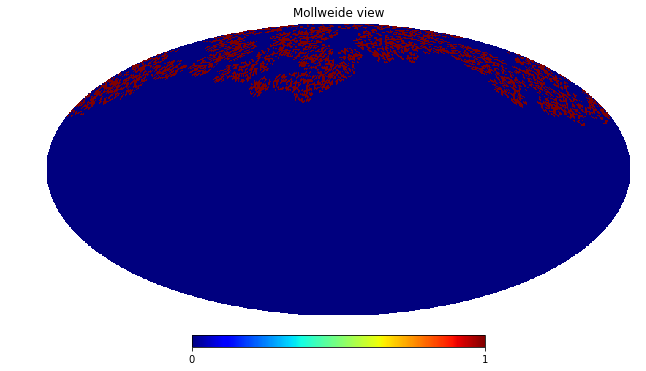

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
(49152,)
2500.0


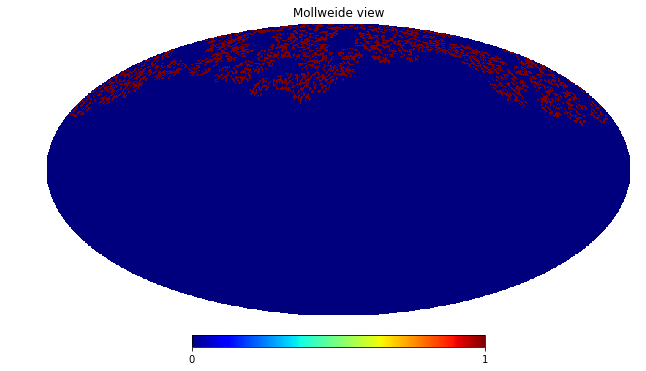

In [88]:
# testing the getSubMatrix routine

# need mask and submask
maskFile4 = '/Data/PSG/small_masks/ISWmask_din1_R010_trunc3000.fits'  #47 minutes to make covMat for this
maskFile5 = '/Data/PSG/small_masks/ISWmask_din1_R010_trunc2500.fits'
# This is not a submask.  It contains pixels outside the bigger mask.  
# That makes it good for checking the execution of the error condition.

nested = True
mask = hp.read_map(maskFile4,nest=nested)
print mask.shape
print np.sum(mask)

hp.mollview(mask, nest=True)
plt.show()

nested = True
mask = hp.read_map(maskFile5,nest=nested)
print mask.shape
print np.sum(mask)

hp.mollview(mask, nest=True)
plt.show()



In [81]:
startTime = time.time()
myCovMat2 = CovMatrix(maskFile=maskFile4, powerFile=ISWinFile, highpass=12, beamSmooth=True, pixWin=True, nested=True)
print 'time elapsed: ',int((time.time()-startTime)/60),' minutes'

print 'big matrix shape: ',myCovMat2.getCovMat().shape

# get submatrix
subMat = myCovMat2.getSubMatrix(maskFile5)
print 'sub matrix shape: ',subMat.shape

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Shape of unitVectors:  (3, 3000)
[[1.         0.98909588 0.9830441  ... 0.45321681 0.45548149 0.46956922]
 [0.         1.         0.99931074 ... 0.33232119 0.33705834 0.35228026]
 [0.         0.         1.         ... 0.30417299 0.3097025  0.3251565 ]
 ...
 [0.         0.         0.         ... 1.         0.99945649 0.99912725]
 [0.         0.         0.         ... 0.         1.         0.99986245]
 [0.         0.         0.         ... 0.         0.         1.        ]]
lmax cutoff imposed at l= 250
starting row  0
starting row  1
starting row  2
starting row  3
starting row  4
starting row  5
starting row  6
starting row  7
starting row  8
starting row  9
starting row  10
starting row  11
starting row  12
starting row  13
starting row  14
starting row  15
starting row  16
starting row  17
starting row  18
starting row  19
starting row  20
starting row  21
start

starting row  427
starting row  428
starting row  429
starting row  430
starting row  431
starting row  432
starting row  433
starting row  434
starting row  435
starting row  436
starting row  437
starting row  438
starting row  439
starting row  440
starting row  441
starting row  442
starting row  443
starting row  444
starting row  445
starting row  446
starting row  447
starting row  448
starting row  449
starting row  450
starting row  451
starting row  452
starting row  453
starting row  454
starting row  455
starting row  456
starting row  457
starting row  458
starting row  459
starting row  460
starting row  461
starting row  462
starting row  463
starting row  464
starting row  465
starting row  466
starting row  467
starting row  468
starting row  469
starting row  470
starting row  471
starting row  472
starting row  473
starting row  474
starting row  475
starting row  476
starting row  477
starting row  478
starting row  479
starting row  480
starting row  481
starting r

starting row  883
starting row  884
starting row  885
starting row  886
starting row  887
starting row  888
starting row  889
starting row  890
starting row  891
starting row  892
starting row  893
starting row  894
starting row  895
starting row  896
starting row  897
starting row  898
starting row  899
starting row  900
starting row  901
starting row  902
starting row  903
starting row  904
starting row  905
starting row  906
starting row  907
starting row  908
starting row  909
starting row  910
starting row  911
starting row  912
starting row  913
starting row  914
starting row  915
starting row  916
starting row  917
starting row  918
starting row  919
starting row  920
starting row  921
starting row  922
starting row  923
starting row  924
starting row  925
starting row  926
starting row  927
starting row  928
starting row  929
starting row  930
starting row  931
starting row  932
starting row  933
starting row  934
starting row  935
starting row  936
starting row  937
starting r

starting row  1321
starting row  1322
starting row  1323
starting row  1324
starting row  1325
starting row  1326
starting row  1327
starting row  1328
starting row  1329
starting row  1330
starting row  1331
starting row  1332
starting row  1333
starting row  1334
starting row  1335
starting row  1336
starting row  1337
starting row  1338
starting row  1339
starting row  1340
starting row  1341
starting row  1342
starting row  1343
starting row  1344
starting row  1345
starting row  1346
starting row  1347
starting row  1348
starting row  1349
starting row  1350
starting row  1351
starting row  1352
starting row  1353
starting row  1354
starting row  1355
starting row  1356
starting row  1357
starting row  1358
starting row  1359
starting row  1360
starting row  1361
starting row  1362
starting row  1363
starting row  1364
starting row  1365
starting row  1366
starting row  1367
starting row  1368
starting row  1369
starting row  1370
starting row  1371
starting row  1372
starting row

starting row  1753
starting row  1754
starting row  1755
starting row  1756
starting row  1757
starting row  1758
starting row  1759
starting row  1760
starting row  1761
starting row  1762
starting row  1763
starting row  1764
starting row  1765
starting row  1766
starting row  1767
starting row  1768
starting row  1769
starting row  1770
starting row  1771
starting row  1772
starting row  1773
starting row  1774
starting row  1775
starting row  1776
starting row  1777
starting row  1778
starting row  1779
starting row  1780
starting row  1781
starting row  1782
starting row  1783
starting row  1784
starting row  1785
starting row  1786
starting row  1787
starting row  1788
starting row  1789
starting row  1790
starting row  1791
starting row  1792
starting row  1793
starting row  1794
starting row  1795
starting row  1796
starting row  1797
starting row  1798
starting row  1799
starting row  1800
starting row  1801
starting row  1802
starting row  1803
starting row  1804
starting row

starting row  2185
starting row  2186
starting row  2187
starting row  2188
starting row  2189
starting row  2190
starting row  2191
starting row  2192
starting row  2193
starting row  2194
starting row  2195
starting row  2196
starting row  2197
starting row  2198
starting row  2199
starting row  2200
starting row  2201
starting row  2202
starting row  2203
starting row  2204
starting row  2205
starting row  2206
starting row  2207
starting row  2208
starting row  2209
starting row  2210
starting row  2211
starting row  2212
starting row  2213
starting row  2214
starting row  2215
starting row  2216
starting row  2217
starting row  2218
starting row  2219
starting row  2220
starting row  2221
starting row  2222
starting row  2223
starting row  2224
starting row  2225
starting row  2226
starting row  2227
starting row  2228
starting row  2229
starting row  2230
starting row  2231
starting row  2232
starting row  2233
starting row  2234
starting row  2235
starting row  2236
starting row

starting row  2618
starting row  2619
starting row  2620
starting row  2621
starting row  2622
starting row  2623
starting row  2624
starting row  2625
starting row  2626
starting row  2627
starting row  2628
starting row  2629
starting row  2630
starting row  2631
starting row  2632
starting row  2633
starting row  2634
starting row  2635
starting row  2636
starting row  2637
starting row  2638
starting row  2639
starting row  2640
starting row  2641
starting row  2642
starting row  2643
starting row  2644
starting row  2645
starting row  2646
starting row  2647
starting row  2648
starting row  2649
starting row  2650
starting row  2651
starting row  2652
starting row  2653
starting row  2654
starting row  2655
starting row  2656
starting row  2657
starting row  2658
starting row  2659
starting row  2660
starting row  2661
starting row  2662
starting row  2663
starting row  2664
starting row  2665
starting row  2666
starting row  2667
starting row  2668
starting row  2669
starting row

AttributeError: CovMatrix instance has no attribute 'getSubMatrix'

In [85]:
# save covariance matrix
myCovMat2.covSave(saveFile = 'covar3000.npy')
print 'done.'

done.


In [91]:
myCovMat3 = CovMatrix(loadFile='covar3000.npy',maskFile=maskFile4, powerFile=ISWinFile, 
                      highpass=12, beamSmooth=True, pixWin=True, nested=True)
print 'big matrix shape: ',myCovMat3.getCovMat().shape

# get submatrix
subMat = myCovMat3.getSubMatrix(maskFile4)
print 'sub matrix shape: ',subMat.shape

 Loaded covariance matrix from file.
big matrix shape:  (3000, 3000)
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
looping through indices to create sub-matrix...
done


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:335: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


sub matrix shape:  (3000, 3000)


# Repeat the testing with the code running from a separate module

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Shape of unitVectors:  (3, 100)
[[1.         0.99102856 0.99442634 ... 0.66959702 0.68401188 0.70735161]
 [0.         1.         0.99950155 ... 0.6159253  0.63100042 0.65879822]
 [0.         0.         1.         ... 0.63646141 0.6512698  0.6780486 ]
 ...
 [0.         0.         0.         ... 1.         0.99980814 0.9982712 ]
 [0.         0.         0.         ... 0.         1.         0.99909169]
 [0.         0.         0.         ... 0.         0.         1.        ]]
lmax cutoff imposed at l= 250
starting row  0
starting row  1
starting row  2
starting row  3
starting row  4
starting row  5
starting row  6
starting row  7
starting row  8
starting row  9
starting row  10
starting row  11
starting row  12
starting row  13
starting row  14
starting row  15
starting row  16
starting row  17
starting row  18
starting row  19
starting row  20
starting row  21
starti

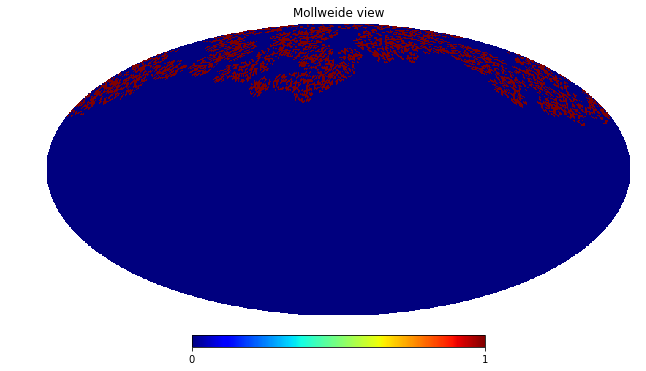

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
(49152,)
2500.0


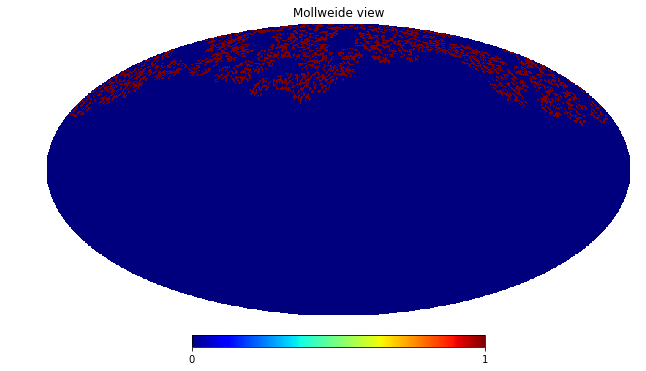

Loaded covariance matrix from file.
big matrix shape:  (3000, 3000)
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
looping through indices to create sub-matrix...
done


CovMatrix.py:352: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  subCmat = cMatrix[np.meshgrid(subVec,subVec)]  #.transpose() # transpose not needed for symmetric


sub matrix shape:  (3000, 3000)


In [92]:
import CovMatrix
CovMatrix.test()